In [15]:
import pandas as pd
import numpy as np
import math
import pickle
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [3]:
# データベースの情報
server = 'gciteam16.database.windows.net'
database = 'mynavi-database'
username = 'gciteam16'
password = 'Password0'
port =1433

In [4]:
# 接続エンジンの作成
engine_config = "?driver=ODBC+Driver+13+for+SQL+Server?charset=shift-jis"
db_settings = {
    "host": server,
    "database": database,
    "user": username,
    "password": password,
    "port":port,
    "config_query":engine_config
}
engine = create_engine('mssql+pyodbc://{user}:{password}@{host}:{port}/{database}{config_query}'.format(**db_settings))

In [5]:
query = "SELECT * FROM analytical_data_table"
analytical_data = pd.read_sql(query, con=engine)

# 分析データの確認

<h3>データ整形

In [7]:
X = analytical_data.iloc[:,3:]
y = analytical_data.iloc[:,:3].rent

<h3>予測モデルの読み込み

In [6]:
with open('../../gci_project_storage/RF_models.pickle', mode='rb') as f:
     RF_models = pickle.load(f)

In [7]:
RF_avoid_0_to_7682 = RF_models["RF_avoid_0_to_7682"]
RF_avoid_7682_to_15364 = RF_models["RF_avoid_7682_to_15364"]
RF_avoid_15364_to_23046 = RF_models["RF_avoid_15364_to_23046"]
RF_avoid_23046_to_30728 = RF_models["RF_avoid_23046_to_30728"]
RF_whole_data = RF_models["RF_whole_data"]

In [8]:
with open('../../gci_project_storage/train_data_urls.pickle', mode='rb') as f:
    train_data_urls = pickle.load(f)

In [9]:
#予測値を出す関数
def get_pred(DF_analytical_data):
    if(list(DF_analytical_data.url)[0] in list(train_data_urls.iloc[pd.Series(range(0,7682))])):
        print(1)
        return RF_avoid_0_to_7682.predict(DF_analytical_data.iloc[:,3:])[0]
    if(list(DF_analytical_data.url)[0] in list(train_data_urls.iloc[pd.Series(range(7682,15364))])):
        print(2)
        return RF_avoid_7682_to_15364.predict(DF_analytical_data.iloc[:,3:])[0]
    if(list(DF_analytical_data.url)[0] in list(train_data_urls.iloc[pd.Series(range(15364,23046))])):
        print(3)
        return RF_avoid_15364_to_23046.predict(DF_analytical_data.iloc[:,3:])[0]
    if(list(DF_analytical_data.url)[0] in list(train_data_urls.iloc[pd.Series(range(23046,30728))])):
        print(4)
        return RF_avoid_23046_to_30728.predict(DF_analytical_data.iloc[:,3:])[0]
    else:
        print(5)
        return RF_whole_data.predict(DF_analytical_data.iloc[:,3:])[0]

In [61]:
DF_analytical_data = analytical_data[analytical_data.index==3312]
get_pred(DF_analytical_data)

3


8.9034500000000012

<h3>緯度経度で選択

In [37]:
#緯度・経度のスケール
lat_mean = analytical_data.address_lat.mean()
lat_500m = (90/10000)*(1/math.cos(math.pi*lat_mean/180))*0.500
lng_500m = (90/10000)*0.500

In [62]:
arg_dict = {
    "lat_500m" : lat_500m
    ,"lng_500m" : lng_500m
    ,"sup_lat" : list(DF_analytical_data.address_lat)[0] + lat_500m
    ,"inf_lat" : list(DF_analytical_data.address_lat)[0] - lat_500m
    ,"sup_lng" : list(DF_analytical_data.address_lng)[0] + lng_500m
    ,"inf_lng" : list(DF_analytical_data.address_lng)[0] - lng_500m
    ,"DF_analytical_data_lat" : list(DF_analytical_data.address_lat)[0]
    ,"DF_analytical_data_lng" : list(DF_analytical_data.address_lng)[0]
}


query = """
    SELECT * FROM 
        (
        SELECT * FROM analytical_data_table 
            WHERE 
                (address_lat < {sup_lat}) 
                and (address_lat > {inf_lat})
                and (address_lng < {sup_lng})
                and (address_lng > {inf_lng}) 
        ) as Sub_Table
        WHERE 
            SQUARE((Sub_Table.address_lat-{DF_analytical_data_lat})/{lat_500m})
            + SQUARE((Sub_Table.address_lng-{DF_analytical_data_lng})/{lng_500m}) 
            < 1
    ;
    """.format(**arg_dict)

regional_data = pd.read_sql(query, con=engine)

In [63]:
regional_data.shape

(7224, 435)

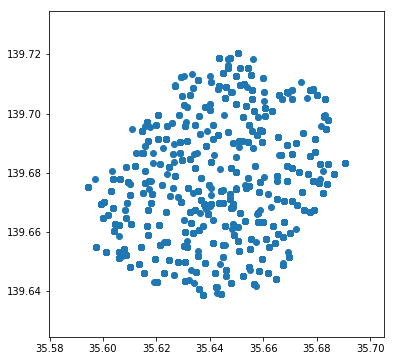

In [65]:
plt.figure(figsize=(6,6))
plt.scatter(regional_data.address_lat,regional_data.address_lng)
plt.show()